## **I. Tổng quan về thuật toán Louvain**

**1. Giới thiệu**
- Thuật toán Louvain là một phương pháp hiệu quả để phát hiện cộng đồng trong đồ thị, được giới thiệu bởi Blondel và cộng sự vào năm 2008. 
- Thuật toán hoạt động bằng cách tối đa hóa Modularity, một chỉ số đo lường mức độ chia đồ thị thành các cộng đồng có kết nối nội bộ chặt chẽ.

**2. Nguyên lý hoạt động**
Thuật toán Louvain hoạt động qua hai bước lặp lại:

- **Bước 1: Tối ưu hóa cục bộ**
    - Mỗi đỉnh trong đồ thị ban đầu được coi là một cộng đồng riêng lẻ. 
    - Tiến hành kiểm tra xem việc chuyển một đỉnh từ cộng đồng hiện tại sang một cộng đồng lân cận có làm tăng Modularity không.
    - Nếu việc chuyển này làm tăng Modularity, đỉnh sẽ được di chuyển sang cộng đồng đó.
- **Bước 2: Tạo đồ thị siêu cấp**
    - Sau khi cộng đồng được xác định, mỗi cộng đồng được gộp lại thành một đỉnh siêu cấp trong một đồ thị mới.
    - Các cạnh giữa các cộng đồng trong đồ thị gốc trở thành trọng số của cạnh giữa các đỉnh trong đồ thị siêu cấp. 
    - Quá trình lại tiếp tục từ bước 1 trên đồ thị siêu cấp này.
    
**3. Ưu điểm**
- **Hiệu quả cao**: Xử lý tốt với đồ thị lớn nhờ cấu trúc lặp lại đơn giản.
- **Linh hoạt**: Ứng dụng được cho cả đồ thị không trọng số và đồ thị trọng số.
- **Chất lượng giải pháp tốt**: Thường tạo ra các cộng đồng có độ chính xác cao và Modularity lớn.

**4. Hạn chế**
- **Nhạy cảm với các thông số ban đầu**: Kết quả có thể bị ảnh hưởng bởi cách khởi tạo.
- **Hiệu ứng độ phân giải**: Có thể bỏ qua các cộng đồng nhỏ trong các đồ thị lớn.


## **II. Tổng quan về các chỉ số đánh giá việc phát hiện cộng đồng**
**1. Modularity ($Q$)**

$Q = \frac{1}{2m} \sum_{i,j} \left[ A_{ij} - \frac{k_i k_j}{2m} \right] \delta(c_i, c_j)$

- $Q$: Đánh giá chất lượng phân hoạch cộng đồng.
- $A_{ij}$: Trọng số giữa đỉnh $i$ và $j$.
- $k_i, k_j$: Tổng trọng số kết nối với đỉnh $i$ và $j$.
- $m$: Tổng trọng số của đồ thị.
- $\delta (c_i, c_j)$: Hàm Kronecker, bằng 1 nếu $c_i = c_j$, ngược lại là 0.

Phạm vi: $[−1,1]$

Thế nào là tốt:
- Modularity cao $(Q \to 1)$: Các cộng đồng được phân chia rõ ràng, với các cạnh tập trung bên trong cộng đồng và ít kết nối ra bên ngoài.
- Modularity thấp hoặc âm** $(Q \to -1)$: Phân chia không tốt hoặc không có cấu trúc cộng đồng rõ ràng.

**2. Conductance**

$\phi(S) = \frac{\text{cut}(S, \overline{S})}{\min(\text{vol}(S), \text{vol}(\overline{S}))}$

- $\text{cut}(S, \overline{S})$: Tổng trọng số các cạnh giữa cộng đồng $S$ và phần còn lại $\overline{S}$.
- $\text{vol}(S)$: Tổng trọng số các cạnh nối với các nút trong $S$.

Phạm vi: $[0,1]$

Thế nào là tốt:
- Conductance thấp $(\phi \to 0)$: Các cộng đồng có kết nối nội bộ chặt chẽ và ít cạnh ra bên ngoài.
- Conductance cao $(\phi \to 1)$: Cộng đồng bị phân chia kém hoặc không rõ ràng.

**3. Normalized Cut**

$\text{NCut}(S, \overline{S}) = \frac{\text{cut}(S, \overline{S})}{\text{vol}(S)} + \frac{\text{cut}(S, \overline{S})}{\text{vol}(\overline{S})}$

Phạm vi:
- Không giới hạn, nhưng giá trị càng nhỏ càng tốt.

Thế nào là tốt:
- Normalized Cut thấp: Các cộng đồng có sự chia tách rõ ràng với ít cạnh giữa các cộng đồng.

**4. Silhouette Score**

$s(i) = \frac{b(i) - a(i)}{\max(a(i), b(i))}$

- $a(i)$: Khoảng cách trung bình từ nút i đến các nút trong cùng cộng đồng.
- $b(i)$: Khoảng cách trung bình từ nút i đến các nút trong cộng đồng gần nhất.

Phạm vi: $[−1,1]$

Thế nào là tốt:
- $s(i) \to 1$: Nút i được gán chính xác vào cộng đồng.
- $s(i) \to −1$: Nút i bị gán sai cộng đồng.


In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
from networkx.algorithms import community

In [2]:
class CommunityGraph(nx.Graph):
    def __init__(self, graph):
        self.graph = graph
        self.partitions = {}
        self.metrics = pd.DataFrame()

    def detect_girvan_newman(self):
        generator = community.girvan_newman(self.graph)
        best_partition = max(
            generator, key=lambda partition: community.modularity(self.graph, partition)
        )
        self.partitions["Girvan-Newman"] = list(best_partition)

    def detect_label_propagation(self):
        partition = list(community.label_propagation_communities(self.graph))
        self.partitions["Label Propagation"] = partition

    def detect_louvain(self):
        partition = list(community.louvain_communities(self.graph))
        self.partitions["Louvain"] = partition

    def calculate_metrics(self):
        metrics_data = []
        for name, communities in self.partitions.items():
            metrics_data.append(
                {
                    "Algorithm": name,
                    "Num Communities": len(communities),
                    "Modularity": community.modularity(self.graph, communities),
                }
            )
        self.metrics = pd.DataFrame(metrics_data)

    def create_community_node_colors(self, communities):
        node_colors = []
        for node in self.graph:
            for idx, comm in enumerate(communities):
                if node in comm:
                    node_colors.append(plt.cm.jet(idx / len(communities)))
                    break
        return node_colors

    def visualize_communities(self):
        fig, axes = plt.subplots(1, len(self.partitions), figsize=(20, 6))
        for ax, (name, communities) in zip(axes, self.partitions.items()):
            node_colors = self.create_community_node_colors(communities)
            pos = nx.spring_layout(self.graph, k=0.3, iterations=50, seed=2)
            modularity_score = community.modularity(self.graph, communities)
            ax.set_title(
                f"{name}\n{len(communities)} communities "
                f"(Modularity: {modularity_score:.3f})"
            )
            nx.draw(
                self.graph,
                pos=pos,
                node_size=500,
                node_color=node_colors,
                with_labels=True,
                font_size=10,
                ax=ax,
            )
        plt.tight_layout()
        plt.show()

    def plot_metrics(self):
        if self.metrics.empty:
            print("Metrics have not been calculated yet.")
            return

        fig, axes = plt.subplots(1, 2, figsize=(18, 7))

        # Bar chart for comparing 'Num Communities'
        axes[0].bar(
            self.metrics["Algorithm"], self.metrics["Num Communities"], color="#8E44AD"
        )
        axes[0].set_title("Num Communities Comparison")
        axes[0].set_xlabel("Algorithm")
        axes[0].set_ylabel("Num Communities")

        # Bar chart for comparing Modularity
        axes[1].bar(
            self.metrics["Algorithm"], self.metrics["Modularity"], color="#F2D140"
        )
        axes[1].set_title("Modularity Comparison")
        axes[1].set_xlabel("Algorithm")
        axes[1].set_ylabel("Modularity")

        plt.tight_layout()
        plt.show()

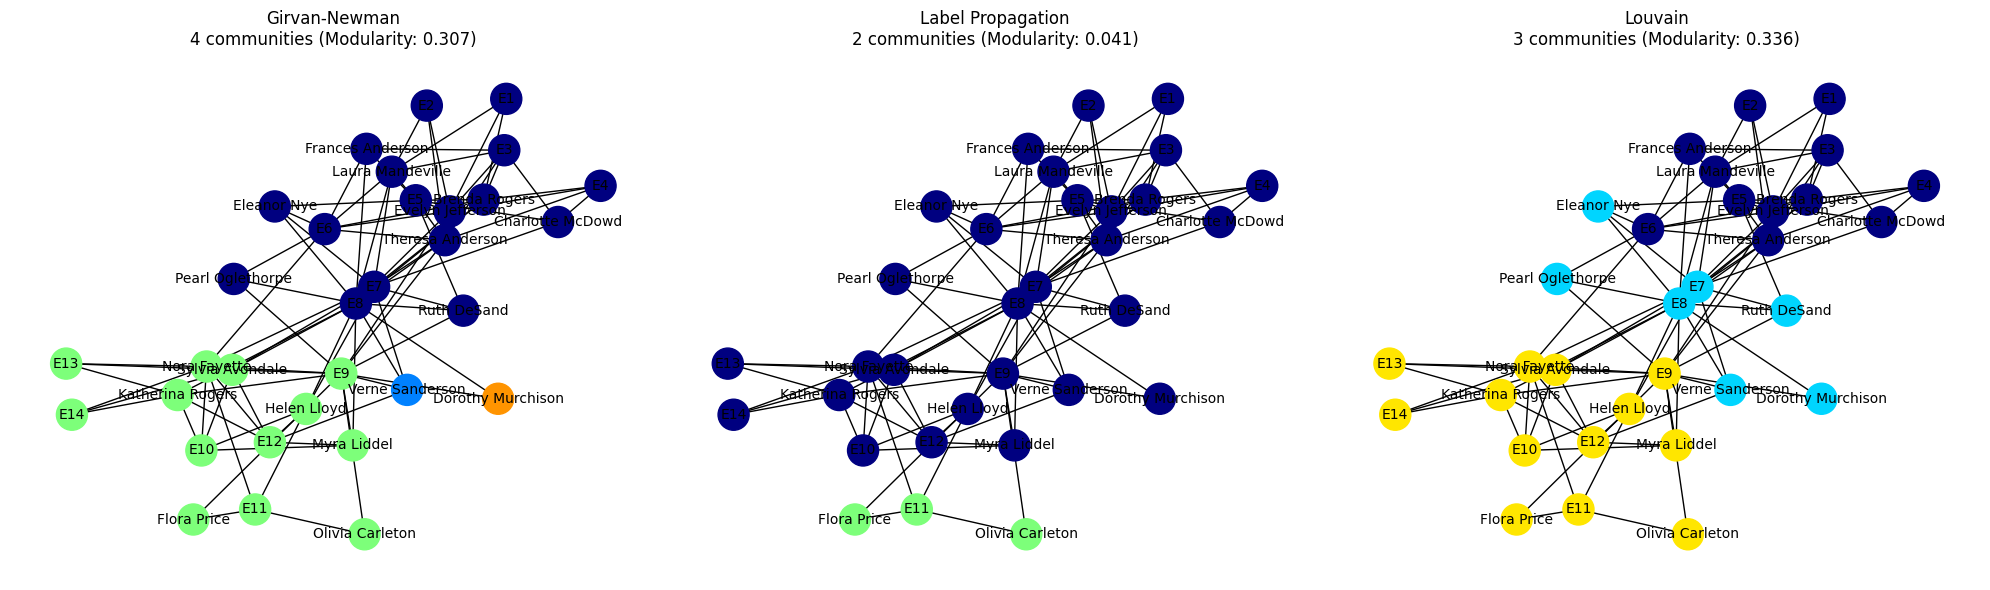

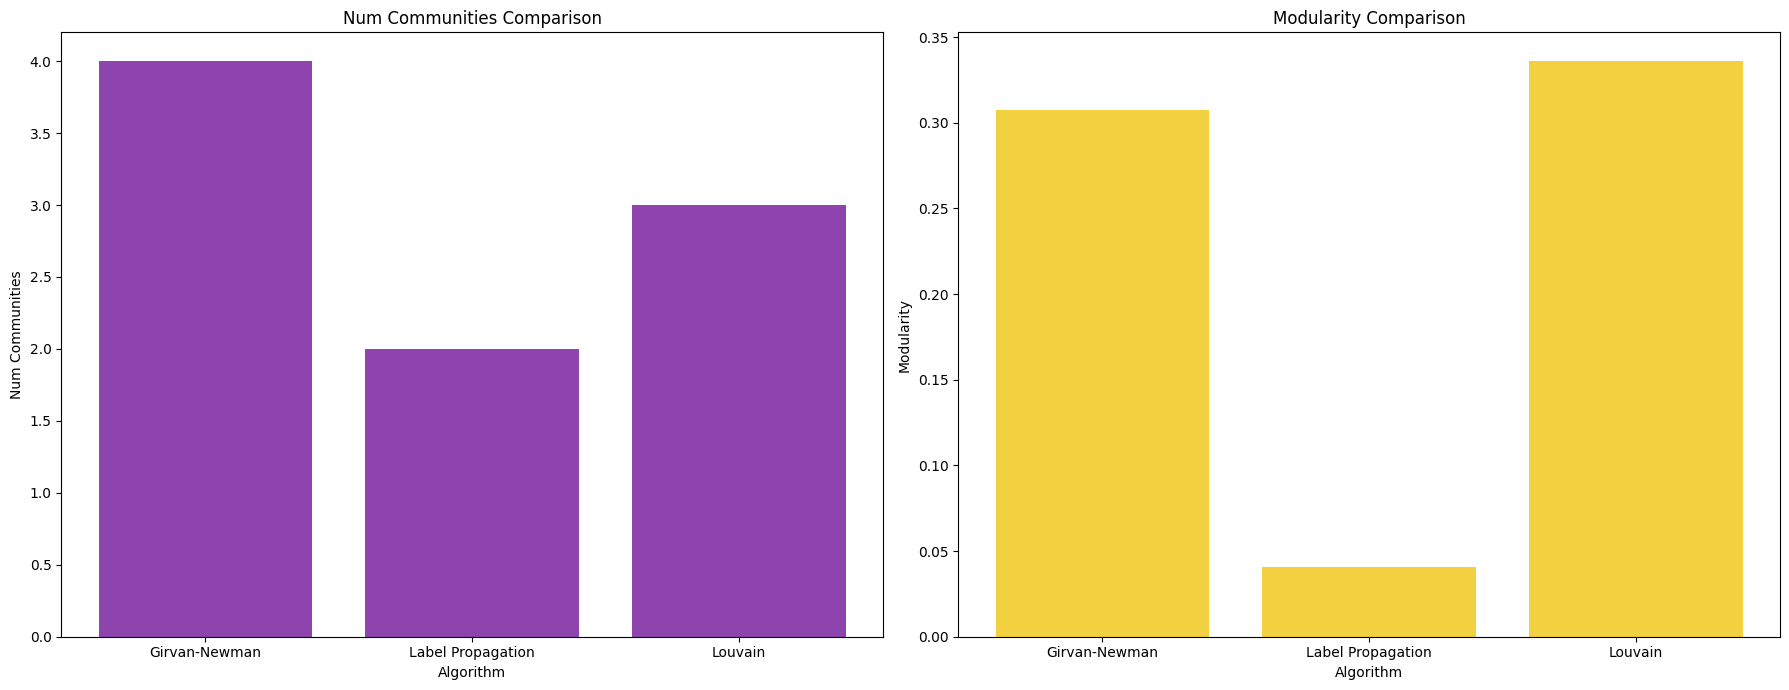

In [3]:
G = nx.davis_southern_women_graph()
detector = CommunityGraph(G)
detector.detect_girvan_newman()
detector.detect_label_propagation()
detector.detect_louvain()
detector.calculate_metrics()
detector.visualize_communities()
detector.plot_metrics()